<a href="https://colab.research.google.com/github/olaf-ys/NLP---News-Topic-Identification/blob/main/ba820_proj_AG_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
import csv
import pandas as pd
import datetime
import numpy as np

# NLP
import re
import spacy

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora, models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklean
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, classification_report
from sklearn.ensemble import RandomForestClassifier

# deep learning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, SimpleRNN
from keras.callbacks import EarlyStopping
from keras import backend as K

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load, clean, and sample the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# List to hold the corrected data
data = []

# Temporary list to hold fields that span multiple lines
current_fields = []

# Open the file and read line by line
with open('/content/drive/MyDrive/newsSpace.txt', 'r', encoding='ISO-8859-1') as file:
    for line in file:
        # Check if the line ends with a backslash indicating continuation
        if line.endswith('\\\n'):
            # Add the current line's content (except for the backslash and newline) to the current fields
            current_fields.append(line[:-2])
        else:
            # This line does not end with a backslash, so it is the end of the current entry
            # Combine any previously accumulated fields with the current line
            current_fields.append(line)
            full_entry = ''.join(current_fields)

            # Split the full entry into fields using the tab delimiter
            fields = full_entry.rstrip('\n').split('\t')

            # Ensure that each line has the correct number of fields
            if len(fields) == 9:
                data.append(fields)

            # Reset the current fields list for the next entry
            current_fields = []

# Convert the corrected data list to a DataFrame
df = pd.DataFrame(data, columns=['source', 'url', 'title', 'image', 'category', 'description', 'rank', 'pubdate', 'video'])

# Display the first few rows of the DataFrame to ensure correctness
df.head()

,source,url,title,image,category,description,rank,pubdate,video
0,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Wall St. Pullback Reflects Tech Blowout (Reuters),none,Business,"Reuters - Wall Street's long-playing drama,""Wa...",5,0000-00-00 00:00:00,\N
1,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Wall St. Bears Claw Back Into the Black (Reuters),none,Business,"Reuters - Short-sellers, Wall Street's dwindli...",5,0000-00-00 00:00:00,\N
2,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Carlyle Looks Toward Commercial Aerospace (Reu...,none,Business,Reuters - Private investment firm Carlyle Grou...,5,0000-00-00 00:00:00,\N
3,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Oil and Economy Cloud Stocks' Outlook (Reuters),none,Business,Reuters - Soaring crude prices plus worriesabo...,5,0000-00-00 00:00:00,\N
4,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Iraq Halts Oil Exports from Main Southern Pipe...,none,Business,Reuters - Authorities have halted oil exportfl...,5,0000-00-00 00:00:00,\N


sample 5000 data points from 'Business', 'Entertainment', 'Sports', 'Sci/Tech'

In [4]:
# Import pandas library
import pandas as pd

sampled_category = ['Business', 'Entertainment', 'Sports', 'Sci/Tech']

lst = []

for i in sampled_category:
  lst.append(df[df['category'] == i].sample(n=5000, random_state=42))

data = pd.concat(lst)

data = data[['title', 'description', 'category']]

data['text'] = data['title'] + ' ' + data['description']

data = data[['text', 'category']].reset_index(drop=True)

data.head()

,text,category
0,Microsoft on Sale Mr. Softy lures PeopleSoft c...,Business
1,IBM &#39;to sell PC business&#39; IBM is repor...,Business
2,Gartner buys Meta Group Both Gartner and Meta ...,Business
3,Nikkei Dips for a 2nd Straight Session TOKYO ...,Business
4,GM Profit Falls on European Losses Here's how...,Business


# Preprocessing

In [5]:
# Set pandas to display the full content of text columns
pd.set_option('display.max_colwidth', None)

# Define a function to clean the text
def clean_text(text):

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)  # Remove special characters and digits
    text = re.sub(r'\s+', ' ', text)  # Remove extra white spaces

    return text

# Apply the cleaning function to the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

# Show the first few rows of the cleaned text
data[['text', 'cleaned_text']].head()

,text,cleaned_text
0,"Microsoft on Sale Mr. Softy lures PeopleSoft customers with deep discounts, but investors shouldn't worry. Much.",microsoft on sale mr softy lures peoplesoft customers with deep discounts but investors shouldn t worry much
1,IBM &#39;to sell PC business&#39; IBM is reportedly in talks to sell its personal computer business. It would mark the end of an era for the company that brought the computer into the mainstream when it began selling its desktop PC to corporations and consumers in 1981.,ibm to sell pc business ibm is reportedly in talks to sell its personal computer business it would mark the end of an era for the company that brought the computer into the mainstream when it began selling its desktop pc to corporations and consumers in
2,"Gartner buys Meta Group Both Gartner and Meta Group are headquartered in Stamford so costs related to combining operations should be minimized. Gartner is known to have the largest segment of the research market, a leader in information technology research.",gartner buys meta group both gartner and meta group are headquartered in stamford so costs related to combining operations should be minimized gartner is known to have the largest segment of the research market a leader in information technology research
3,"Nikkei Dips for a 2nd Straight Session TOKYO (Reuters) - Tokyo's Nikkei fell for a second straight session to close 0.99 percent lower on Tuesday as selling increased after the dollar's retreat below 103 yen, putting more pressure on exporters such as Sony Corp",nikkei dips for a nd straight session tokyo reuters tokyo s nikkei fell for a second straight session to close percent lower on tuesday as selling increased after the dollar s retreat below yen putting more pressure on exporters such as sony corp
4,"GM Profit Falls on European Losses Here's how hard it is to navigate today's fickle auto industry: Last year, General Motors Corp. managed to preserve profit in North America, but its market share tumbled. At the same time, GM's share of the European market rose to a five-year high, but the company lost a huge amount of money there.",gm profit falls on european losses here s how hard it is to navigate today s fickle auto industry last year general motors corp managed to preserve profit in north america but its market share tumbled at the same time gm s share of the european market rose to a five year high but the company lost a huge amount of money there


### tokenize, remove stop words, lemmatize

In [6]:
import spacy
import pandas as pd

# Load the model, disabling unnecessary pipeline components (i.e. dependency parsing and named entity recognition)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def process_text_list(texts):
    # Process a list of texts in batches using nlp.pipe
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=50): # use batch training to parallel computation
        # For each doc, extract lemmas of non-stop words
        lemmatized_text = [token.lemma_ for token in doc if not token.is_stop]
        processed_texts.append(lemmatized_text)
    return processed_texts

In [7]:
# apply process_text_list
processed_texts = process_text_list(data['cleaned_text'].tolist())

data['preprocessed_text'] = processed_texts

data[["cleaned_text", "preprocessed_text"]].head()

,cleaned_text,preprocessed_text
0,microsoft on sale mr softy lures peoplesoft customers with deep discounts but investors shouldn t worry much,"[microsoft, sale, mr, softy, lure, peoplesoft, customer, deep, discount, investor, shouldn, t, worry]"
1,ibm to sell pc business ibm is reportedly in talks to sell its personal computer business it would mark the end of an era for the company that brought the computer into the mainstream when it began selling its desktop pc to corporations and consumers in,"[ibm, sell, pc, business, ibm, reportedly, talk, sell, personal, computer, business, mark, end, era, company, bring, computer, mainstream, begin, sell, desktop, pc, corporation, consumer]"
2,gartner buys meta group both gartner and meta group are headquartered in stamford so costs related to combining operations should be minimized gartner is known to have the largest segment of the research market a leader in information technology research,"[gartner, buy, meta, group, gartner, meta, group, headquarter, stamford, cost, relate, combine, operation, minimize, gartner, know, large, segment, research, market, leader, information, technology, research]"
3,nikkei dips for a nd straight session tokyo reuters tokyo s nikkei fell for a second straight session to close percent lower on tuesday as selling increased after the dollar s retreat below yen putting more pressure on exporters such as sony corp,"[nikkei, dip, nd, straight, session, tokyo, reuters, tokyo, s, nikkei, fall, second, straight, session, close, percent, lower, tuesday, sell, increase, dollar, s, retreat, yen, put, pressure, exporter, sony, corp]"
4,gm profit falls on european losses here s how hard it is to navigate today s fickle auto industry last year general motors corp managed to preserve profit in north america but its market share tumbled at the same time gm s share of the european market rose to a five year high but the company lost a huge amount of money there,"[gm, profit, fall, european, loss, s, hard, navigate, today, s, fickle, auto, industry, year, general, motors, corp, manage, preserve, profit, north, america, market, share, tumble, time, gm, s, share, european, market, rise, year, high, company, lose, huge, money]"


Determine threshold for min_df/min_count

In [8]:
tokens = data['preprocessed_text'].explode()

# tokens and their frequencies
token_frequency = tokens.value_counts()

token_frequency.describe()

count    39229.000000
mean        18.676056
std        182.982909
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      14208.000000
Name: preprocessed_text, dtype: float64

- The dataset contains a total of 39,229 unique words.
- The median frequency of word occurrences is 2, meaning half of the words appear no more than twice.
- The average frequency of word occurrences is about 18.7, but this figure is likely skewed by a few extremely high-frequency words such as `com`, `http`, `s`, `p`, `img`, etc.
- The most common word appears 14,208 times, while the least common words appear only once.

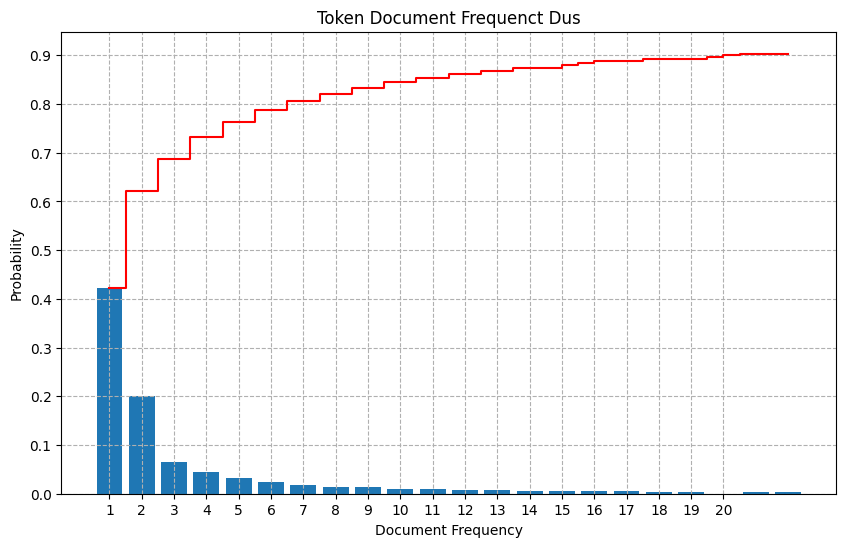

In [9]:
tokens = data['preprocessed_text'].explode()

# tokens and their frequencies
token_frequency = tokens.value_counts()

# frequencies and their times of being observed
frequency_obs = token_frequency.value_counts()

# total obersvations = number of total tokens
total_obs = token_frequency.count()

# frequencies and their prob of being observed
frequency_probability = (frequency_obs/total_obs)[0:21]

cumulative_percentage = frequency_probability.cumsum()

# bar plot
plt.figure(figsize=(10, 6))
plt.bar(frequency_probability.index, frequency_probability.values)
plt.step(frequency_probability.index, cumulative_percentage, where = 'mid', color = 'red')
plt.title('Token Document Frequenct Dus')
plt.xlabel('Document Frequency')
plt.ylabel('Probability')
plt.xticks(range(1, 21))
plt.yticks(np.arange(0, 1, 0.1))
plt.grid(linestyle='--')

plt.show()

- more than 40% of tokens appear no more than once
- more than 60% of tokens appear no more than twice

Therefore, proper thresholds for min_count/min_df can be 2 or 3

## Text Vectorization

### Bag of Words

In [10]:
cv = CountVectorizer()
bow = cv.fit_transform(data['preprocessed_text'].apply(lambda x: ' '.join(x)))
bow_df = pd.DataFrame(bow.toarray(), columns=cv.get_feature_names_out())
bow_df.head()

,aa,aaa,aaaa,aab,aabf,aac,aaca,aacb,aacd,aachen,...,zzdyg,zzggatjcqa,zzhv,zzkkjcsax,zzl,zzm,zzqn,zzuntyi,zzynjzd,zzyu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [11]:
tfidf = TfidfVectorizer(min_df = 3) # 3 is based on the previous conclusion
tfidf_matrix = tfidf.fit_transform(data['preprocessed_text'].apply(lambda x: ' '.join(x)))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.head()

,aa,aaa,aad,aae,aamir,aapl,aaron,ab,aba,abandon,...,zq,zu,zucker,zune,zurich,zvonareva,zw,zwick,zy,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Text Embedding

### Word2Vec

In [12]:
# train a Word2Vec model
w2v = Word2Vec(sentences=data['preprocessed_text'], vector_size=100, window=2, min_count=3, workers=2)

#### average

In [13]:
# average word embedding
def avg(model, doc_tokens):

    # Retrieve vectors for words in the vocabulary from the model
    vectors = [model.wv[word] for word in doc_tokens if word in model.wv.key_to_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Calculate the vector for each document
data['w2v_avg'] = data['preprocessed_text'].apply(lambda doc: avg(w2v, doc))
data['w2v_avg'].head(1)

0    [-0.13509525, 0.2982848, -0.061097566, 0.3737787, 0.09332806, -0.51609015, -0.21579117, 0.29578623, -0.5232875, 0.16044056, -0.101469666, -0.27212015, -0.396696, 0.37438664, 0.0096036615, -0.56623816, 0.007910813, 0.16562901, -0.13051878, -0.28772503, -0.097845115, 0.03007341, -0.09719879, -0.24900655, -0.024553314, 0.060797308, -0.3475523, 0.010526787, -0.2261361, 0.03552557, 0.13480182, -0.10257327, 0.4319266, 0.07452818, 0.22688603, 0.54255205, 0.020036066, -0.34064516, -0.09305957, -0.75619525, 0.043964792, -0.29730132, 0.06280371, 0.12086076, -0.07668516, -0.112662844, -0.24086376, -0.36517236, 0.075844325, -0.06552955, -0.045866027, -0.18776532, -0.004518283, 0.058956724, -0.18911846, -0.13380845, -0.06896893, -0.2549057, -0.6526184, 0.052574474, -0.040811114, 0.19294311, 0.15656838, 0.22821337, -0.23278742, -0.04771504, 0.48992845, 0.42360172, -0.51545364, 0.25508317, 0.11074531, 0.26328138, 0.37358037, 0.04389224, 0.49570325, 0.45158193, 0.14721355, 0.30371118, 0.098563015

#### tf-idf weighted average

In [14]:
# Create a vocabulary and word vector mapping
word2vec_vocab = w2v.wv.index_to_key
word_vector_dict = {word: w2v.wv[word] for word in word2vec_vocab if word in tfidf.vocabulary_}

feature_names = tfidf.get_feature_names_out()

def tfidf_weighted_avg(document, doc_index, tfidf_matrix):
    # Only consider words in both Word2Vec and TF-IDF vocabularies
    valid_words = [word for word in document if word in word_vector_dict]

    # initialize weighted vectors
    weighted_vector = np.zeros(w2v.vector_size)

    if not valid_words:
        return weighted_vector

    # get the tfidf row of the current document
    doc_tfidf = tfidf_matrix[doc_index].tocoo()

    # create a word and tfidf weight mapping
    word_to_tfidf = {feature_names[i]: value for i, value in zip(doc_tfidf.col, doc_tfidf.data)}

    # calculate tf-idf weighted avg
    total_weight = 0.0
    for word in valid_words:
        if word in word_to_tfidf:
            weight = word_to_tfidf[word]
            weighted_vector += weight * word_vector_dict[word]
            total_weight += weight

    if total_weight > 0:
        weighted_vector /= total_weight

    return weighted_vector

w2v_tfidf_weighted_avg = np.array([tfidf_weighted_avg(doc, idx, tfidf_matrix) for idx, doc in enumerate(data['preprocessed_text'])])

w2v_tfidf_weighted_avg

array([[-0.17519841,  0.15325433, -0.04408209, ...,  0.18094589,
         0.35405038,  0.07495607],
       [-0.11735718,  0.39336615,  0.03604307, ...,  0.08667647,
         0.30561559,  0.04419098],
       [-0.13604715,  0.23498703,  0.06967061, ..., -0.00613235,
         0.23311578,  0.04289196],
       ...,
       [-0.08738472,  0.18204198,  0.03902267, ...,  0.02523375,
         0.26320416,  0.1099076 ],
       [-0.07589763,  0.23108162,  0.13560591, ...,  0.06657761,
         0.23205279,  0.15340754],
       [-0.08894504,  0.26993248,  0.11168413, ..., -0.10492551,
         0.28379555,  0.09644991]])

#### idf weighted average

In [15]:
# Create a vocabulary and word vector mapping
word2vec_vocab = w2v.wv.index_to_key
word_vector_dict = {word: w2v.wv[word] for word in word2vec_vocab if word in tfidf.vocabulary_}

def weighted_average_vector(document):
    # Only consider words in both Word2Vec and TF-IDF vocabularies
    valid_words = [word for word in document if word in word_vector_dict]

    if valid_words:

      # Compute TF-IDF weights and corresponding word vectors
      weights = np.array([tfidf.idf_[tfidf.vocabulary_[word]] for word in valid_words])
      vectors = np.array([word_vector_dict[word] for word in valid_words])

    else:
      return np.zeros(w2v.vector_size)

    # Compute the weighted average
    if weights.size > 0:
      weighted_average = np.dot(weights, vectors) / weights.sum()
      return weighted_average

    else:
      return np.zeros(w2v.vector_size)

# Apply the weighted average word vector
w2v_idf_weighted_avg = np.array([weighted_average_vector(doc) for doc in data['preprocessed_text']])
w2v_idf_weighted_avg

array([[-0.17519841,  0.15325433, -0.04408209, ...,  0.18094589,
         0.35405038,  0.07495607],
       [-0.12426   ,  0.35972287,  0.04931145, ...,  0.10184444,
         0.29847515,  0.0516447 ],
       [-0.12905546,  0.24424488,  0.07546682, ...,  0.04737453,
         0.24006207,  0.05171569],
       ...,
       [-0.08989584,  0.18228744,  0.03888369, ...,  0.02328629,
         0.25817896,  0.10712165],
       [-0.06989754,  0.22913487,  0.12960887, ...,  0.06290259,
         0.22983908,  0.14802507],
       [-0.08894504,  0.26993248,  0.11168413, ..., -0.1049255 ,
         0.28379555,  0.09644991]])

### GloVe (Pre-trained)

In [17]:
# load api
import gensim.downloader as api

print(api.info()['models'].keys())

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


In [18]:
# load pretrained model
glove = api.load("glove-wiki-gigaword-100")

idf weighted average

In [19]:
# Create a vocabulary and word vector mapping
word_vector_dict = {word: glove[word] for word in glove.key_to_index if word in tfidf.vocabulary_}

def weighted_average_vector(document):
    # Only consider words in both Word2Vec and TF-IDF vocabularies
    valid_words = [word for word in document if word in word_vector_dict]

    if valid_words:

      # Compute TF-IDF weights and corresponding word vectors
      weights = np.array([tfidf.idf_[tfidf.vocabulary_[word]] for word in valid_words])
      vectors = np.array([word_vector_dict[word] for word in valid_words])

    else:
      return np.zeros(glove.vector_size)

    # Compute the weighted average
    if weights.size > 0:
      weighted_average = np.dot(weights, vectors) / weights.sum()
      return weighted_average

    else:
      return np.zeros(w2v.vector_size)

# Apply the weighted average word vector
glove_idf_weighted_avg = np.array([weighted_average_vector(doc) for doc in data['preprocessed_text']])
glove_idf_weighted_avg

array([[ 0.08301262,  0.14794662,  0.16314122, ..., -0.07583046,
         0.27216457,  0.19456239],
       [ 0.07277598,  0.15601911,  0.11505128, ..., -0.15245221,
         0.85716269,  0.17802454],
       [-0.39085934,  0.0323345 ,  0.01380136, ..., -0.2504151 ,
         0.35702096,  0.23101756],
       ...,
       [-0.11218556,  0.18163195,  0.17389542, ..., -0.2361844 ,
         0.22393456, -0.00699955],
       [-0.23649423,  0.37424035,  0.33494951, ..., -0.3037791 ,
         0.12767743,  0.0169173 ],
       [-0.06285553,  0.0545326 ,  0.24097766, ...,  0.01128499,
         0.51512647,  0.24571222]])

# Modeling

## Random Forest

In [20]:
data.columns

Index(['text', 'category', 'cleaned_text', 'preprocessed_text', 'w2v_avg',
       'doc2vec'],
      dtype='object')

### Bag of Words

In [37]:
y = data['category']
X = data['preprocessed_text'].apply(lambda x: ' '.join(x))

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# vectorize X_train and X_test seperately
cv = CountVectorizer()
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.69      0.86      0.77       995
Entertainment       0.82      0.64      0.72      1024
     Sci/Tech       0.82      0.70      0.76       977
       Sports       0.83      0.94      0.88      1004

     accuracy                           0.78      4000
    macro avg       0.79      0.78      0.78      4000
 weighted avg       0.79      0.78      0.78      4000



### TF-IDF

In [36]:
y = data['category']
X = data['preprocessed_text'].apply(lambda x: ' '.join(x))

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# vectorize X_train and X_test seperately
tfidf = TfidfVectorizer(min_df = 3)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.72      0.81      0.76       995
Entertainment       0.77      0.65      0.71      1024
     Sci/Tech       0.80      0.71      0.75       977
       Sports       0.82      0.93      0.87      1004

     accuracy                           0.78      4000
    macro avg       0.78      0.78      0.77      4000
 weighted avg       0.78      0.78      0.77      4000



### Word2Vec

average

In [22]:
y = data['category']
X = data['w2v_avg'].to_list()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.76      0.73      0.74       995
Entertainment       0.60      0.62      0.61      1024
     Sci/Tech       0.71      0.67      0.69       977
       Sports       0.76      0.79      0.77      1004

     accuracy                           0.70      4000
    macro avg       0.71      0.70      0.70      4000
 weighted avg       0.70      0.70      0.70      4000



TF-IDF weighted average

In [23]:
y = data['category']
X = w2v_tfidf_weighted_avg

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.73      0.69      0.71       995
Entertainment       0.60      0.62      0.61      1024
     Sci/Tech       0.69      0.64      0.66       977
       Sports       0.74      0.81      0.77      1004

     accuracy                           0.69      4000
    macro avg       0.69      0.69      0.69      4000
 weighted avg       0.69      0.69      0.69      4000



IDF weighted average

In [24]:
y = data['category']
X = w2v_idf_weighted_avg

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.74      0.71      0.73       995
Entertainment       0.63      0.64      0.63      1024
     Sci/Tech       0.70      0.67      0.68       977
       Sports       0.77      0.82      0.79      1004

     accuracy                           0.71      4000
    macro avg       0.71      0.71      0.71      4000
 weighted avg       0.71      0.71      0.71      4000



### GloVe (pre-trained, IDF weighted)

In [25]:
y = data['category']
X = glove_idf_weighted_avg

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.80      0.76      0.78       995
Entertainment       0.75      0.72      0.73      1024
     Sci/Tech       0.74      0.77      0.76       977
       Sports       0.89      0.93      0.91      1004

     accuracy                           0.80      4000
    macro avg       0.80      0.80      0.80      4000
 weighted avg       0.80      0.80      0.80      4000



## Deep Learning

### Transfer Learning with GloVe

1. convert each document into vector sequence

In [27]:
# define a function to convert each document in data into vector sequence
def doc_to_vector_sequence(doc, model):
    vector_sequence = []
    for word in doc:
        if word in model.key_to_index:
            vector_sequence.append(model[word])
        else:
            # use zeros if not in the vocabulary
            vector_sequence.append(np.zeros(model.vector_size))
    return np.array(vector_sequence)

# apply function
vector_sequences = [doc_to_vector_sequence(doc, glove) for doc in data['preprocessed_text']]

# verify the result
print(vector_sequences[0].shape)
vector_sequences[0]

(13, 100)


array([[ 0.29296  , -0.20033  ,  0.64765  , ...,  0.21748  ,  1.1448   ,
         0.72374  ],
       [ 0.79338  , -0.033504 ,  0.060543 , ...,  0.34844  ,  0.7957   ,
        -0.2613   ],
       [-0.24683  , -0.045153 , -0.29972  , ..., -0.22978  , -0.63699  ,
        -0.78636  ],
       ...,
       [-0.22835  ,  0.51931  ,  0.080085 , ..., -0.031722 , -0.29727  ,
         0.056813 ],
       [ 0.13482  ,  0.40224  , -0.42266  , ..., -0.27989  ,  0.28937  ,
         0.043783 ],
       [-0.0029325,  0.63036  ,  0.51482  , ..., -0.15467  ,  0.24526  ,
         0.29353  ]], dtype=float32)

2. padding

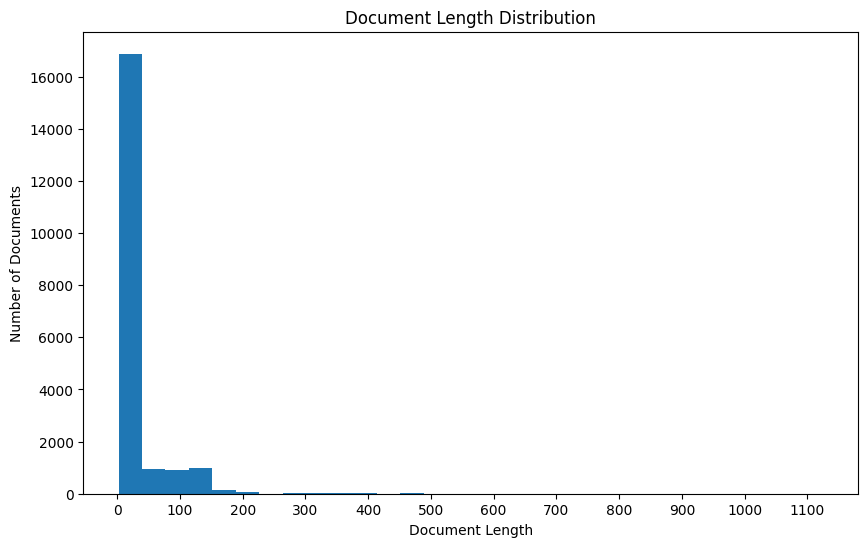

In [28]:
# visualize document length distrib
doc_lengths = [len(doc) for doc in data['preprocessed_text']]

plt.figure(figsize=(10, 6))
plt.hist(doc_lengths, bins=30)
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Number of Documents')
plt.xticks(range(0, max(doc_lengths) + 1, 100))
plt.show()

In [29]:
np.quantile(doc_lengths, 0.99)

178.0199999999968

99% documents are shorter than 180. Therefore 180 can be set as the sequence length

In [30]:
# pad the sequence
padded_sequences = pad_sequences(vector_sequences, maxlen=180, dtype='float32', padding='post', truncating='post')

# verify the result
print(padded_sequences[0].shape)
padded_sequences[0]

(180, 100)


array([[ 0.29296 , -0.20033 ,  0.64765 , ...,  0.21748 ,  1.1448  ,
         0.72374 ],
       [ 0.79338 , -0.033504,  0.060543, ...,  0.34844 ,  0.7957  ,
        -0.2613  ],
       [-0.24683 , -0.045153, -0.29972 , ..., -0.22978 , -0.63699 ,
        -0.78636 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

3. train test split and one-hot encode the target

In [31]:
# one-hot encode target
y = pd.get_dummies(data['category']).values
X = padded_sequences

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
print(y)

(20000, 180, 100)
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]


In [33]:
sequence_len = X.shape[1]
embedding_dim = X.shape[2]

# build model
model = Sequential()

# add a convolution layer to do feature selection
model.add(Conv1D(filters=80, kernel_size=5, activation='relu', input_shape=(sequence_len, embedding_dim)))
model.add(MaxPooling1D(pool_size=4))

# sequential modeling using LSTM
model.add(LSTM(64))

# output layer with 4 nuerons and softmax for muti-classification problem
model.add(Dense(4, activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 176, 80)           40080     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 44, 80)            0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 64)                37120     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 77460 (302.58 KB)
Trainable params: 77460 (302.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
%%time
K.clear_session()
# train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
200/200 [==============================] - 25s 108ms/step - loss: 0.9736 - accuracy: 0.5459 - val_loss: 0.7776 - val_accuracy: 0.7131
Epoch 2/10
200/200 [==============================] - 22s 109ms/step - loss: 0.6514 - accuracy: 0.7723 - val_loss: 0.6401 - val_accuracy: 0.7866
Epoch 3/10
200/200 [==============================] - 22s 112ms/step - loss: 0.5270 - accuracy: 0.8240 - val_loss: 0.5417 - val_accuracy: 0.8194
Epoch 4/10
200/200 [==============================] - 21s 107ms/step - loss: 0.4745 - accuracy: 0.8407 - val_loss: 0.5508 - val_accuracy: 0.8241
Epoch 5/10
200/200 [==============================] - 21s 104ms/step - loss: 0.4247 - accuracy: 0.8640 - val_loss: 0.5295 - val_accuracy: 0.8247
Epoch 6/10
200/200 [==============================] - 21s 108ms/step - loss: 0.3975 - accuracy: 0.8748 - val_loss: 0.5736 - val_accuracy: 0.8128
Epoch 7/10
200/200 [==============================] - 22s 108ms/step - loss: 0.3587 - accuracy: 0.8898 - val_loss: 0.5387 - val_ac

In [35]:
prediction = model.predict(X_test)

# map one-hot encoded y to origin values
cat_names = pd.get_dummies(data['category']).columns.tolist()
y_pred_label = [cat_names[i] for i in np.argmax(prediction, axis=1)]
y_test_label = [cat_names[i] for i in np.argmax(y_test, axis=1)]

print(classification_report(y_test_label, y_pred_label))

125/125 [==============================] - 3s 19ms/step
               precision    recall  f1-score   support

     Business       0.84      0.76      0.80       995
Entertainment       0.70      0.78      0.74      1024
     Sci/Tech       0.79      0.75      0.77       977
       Sports       0.90      0.94      0.92      1004

     accuracy                           0.81      4000
    macro avg       0.81      0.81      0.81      4000
 weighted avg       0.81      0.81      0.81      4000



### Regular LSTM

In [39]:
# get vocabulary size
text = data['preprocessed_text']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

39229

In [43]:
# set parameters
vocab_size = int(vocab_size*0.99)
embedding_dim = 100
sequence_len = 180

# preprocessing text
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>') # '<OOV>' reserves a special index for tokens not in vocabulary list
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
X = pad_sequences(sequences, maxlen=sequence_len, padding='post', truncating='post')
y = pd.get_dummies(data['category']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# build model
model = Sequential()

# add an embedding layer to covert sparse to dense matrix
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_len))

# add a convolution layer to do feature selection
model.add(Conv1D(filters=80, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))

# sequential modeling using LSTM
model.add(LSTM(64))

# output layer with 4 nuerons and softmax for muti-classification problem
model.add(Dense(4, activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 100)          3844700   
                                                                 
 conv1d (Conv1D)             (None, 176, 80)           40080     
                                                                 
 max_pooling1d (MaxPooling1  (None, 44, 80)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                37120     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 3922160 (14.96 MB)
Trainable params: 3922160 (14.96 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [44]:
%%time
K.clear_session()
# train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
200/200 [==============================] - 39s 180ms/step - loss: 1.1374 - accuracy: 0.4445 - val_loss: 0.8679 - val_accuracy: 0.6338
Epoch 2/10
200/200 [==============================] - 34s 172ms/step - loss: 0.6827 - accuracy: 0.7098 - val_loss: 0.7552 - val_accuracy: 0.7194
Epoch 3/10
200/200 [==============================] - 36s 178ms/step - loss: 0.4385 - accuracy: 0.8505 - val_loss: 0.7847 - val_accuracy: 0.7425
Epoch 4/10
200/200 [==============================] - 37s 183ms/step - loss: 0.2915 - accuracy: 0.9122 - val_loss: 0.8417 - val_accuracy: 0.7500
Epoch 5/10
200/200 [==============================] - 38s 189ms/step - loss: 0.2002 - accuracy: 0.9450 - val_loss: 0.7917 - val_accuracy: 0.7747
Epoch 6/10
200/200 [==============================] - 34s 168ms/step - loss: 0.1537 - accuracy: 0.9623 - val_loss: 0.8726 - val_accuracy: 0.7800
Epoch 7/10
200/200 [==============================] - 36s 180ms/step - loss: 0.1261 - accuracy: 0.9695 - val_loss: 0.9557 - val_ac

In [45]:
prediction = model.predict(X_test)

# map one-hot encoded y to origin values
cat_names = pd.get_dummies(data['category']).columns.tolist()
y_pred_label = [cat_names[i] for i in np.argmax(prediction, axis=1)]
y_test_label = [cat_names[i] for i in np.argmax(y_test, axis=1)]

print(classification_report(y_test_label, y_pred_label))

125/125 [==============================] - 3s 19ms/step
               precision    recall  f1-score   support

     Business       0.72      0.82      0.76       995
Entertainment       0.68      0.70      0.69      1024
     Sci/Tech       0.82      0.73      0.78       977
       Sports       0.89      0.85      0.87      1004

     accuracy                           0.77      4000
    macro avg       0.78      0.77      0.78      4000
 weighted avg       0.78      0.77      0.78      4000



### Simple RNN

In [46]:
# set parameters
vocab_size = int(vocab_size*0.99)
embedding_dim = 100
sequence_len = 180

# preprocessing text
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>') # '<OOV>' reserves a special index for tokens not in vocabulary list
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
X = pad_sequences(sequences, maxlen=sequence_len, padding='post', truncating='post')
y = pd.get_dummies(data['category']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# build model
model = Sequential()

# add an embedding layer to covert sparse to dense matrix
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_len))

# add a convolution layer to do feature selection
model.add(Conv1D(filters=80, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))

# sequential modeling using LSTM
model.add(SimpleRNN(64))

# output layer with 4 nuerons and softmax for muti-classification problem
model.add(Dense(4, activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 100)          3806200   
                                                                 
 conv1d (Conv1D)             (None, 176, 80)           40080     
                                                                 
 max_pooling1d (MaxPooling1  (None, 44, 80)            0         
 D)                                                              
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                9280      
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 3855820 (14.71 MB)
Trainable params: 3855820 (14.71 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [47]:
%%time
K.clear_session()
# train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
200/200 [==============================] - 35s 169ms/step - loss: 0.8592 - accuracy: 0.6491 - val_loss: 0.5939 - val_accuracy: 0.7972
Epoch 2/10
200/200 [==============================] - 31s 154ms/step - loss: 0.2790 - accuracy: 0.9118 - val_loss: 0.7234 - val_accuracy: 0.7616
Epoch 3/10
200/200 [==============================] - 30s 149ms/step - loss: 0.1074 - accuracy: 0.9702 - val_loss: 0.8420 - val_accuracy: 0.7475
Epoch 4/10
200/200 [==============================] - 31s 156ms/step - loss: 0.0429 - accuracy: 0.9883 - val_loss: 0.9082 - val_accuracy: 0.7491
Epoch 5/10
200/200 [==============================] - 29s 147ms/step - loss: 0.0394 - accuracy: 0.9897 - val_loss: 0.9504 - val_accuracy: 0.7494
Epoch 6/10
200/200 [==============================] - 29s 148ms/step - loss: 0.0381 - accuracy: 0.9891 - val_loss: 1.1251 - val_accuracy: 0.7459
Epoch 7/10
200/200 [==============================] - 30s 149ms/step - loss: 0.0404 - accuracy: 0.9882 - val_loss: 1.1136 - val_ac

In [48]:
prediction = model.predict(X_test)

# map one-hot encoded y to origin values
cat_names = pd.get_dummies(data['category']).columns.tolist()
y_pred_label = [cat_names[i] for i in np.argmax(prediction, axis=1)]
y_test_label = [cat_names[i] for i in np.argmax(y_test, axis=1)]

print(classification_report(y_test_label, y_pred_label))

125/125 [==============================] - 2s 15ms/step
               precision    recall  f1-score   support

     Business       0.70      0.75      0.72       995
Entertainment       0.72      0.59      0.65      1024
     Sci/Tech       0.64      0.86      0.73       977
       Sports       0.88      0.67      0.76      1004

     accuracy                           0.72      4000
    macro avg       0.73      0.72      0.72      4000
 weighted avg       0.73      0.72      0.72      4000

